In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#PDFs in BDT and sindec?
import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
os.environ['MKL_NUM_THREADS'] = "1"
os.environ['NUMEXPR_NUM_THREADS'] = "1"
os.environ['OMP_NUM_THREADS'] = "1"
os.environ['OPENBLAS_NUM_THREADS'] = "1"
os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import astropy
#from icecube import astro
import histlite as hl
import healpy
import socket
import pickle
import copy
healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)

## Define Settings

In [2]:
selection_version = 'version-001-p00'

host_name = socket.gethostname()

if 'cobalt' in host_name:
    print('Working on Cobalts')
    data_prefix = '/data/user/ssclafani/data/cscd/final'
    ana_dir = '/data/user/ssclafani/data/analyses/'
    plot_dir = '/home/mhuennefeld/public_html/analyses/DNNCascade/plots/review/containment_performance'
    
elif 'phobos' in host_name:
    print('Working on Phobos')
    data_prefix = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/data/cscd/final'
    ana_dir = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/csky/analyses/'
    plot_dir = '/home/mhuennefeld/analyses/DNNCascade/plots/review/containment_performance'
    
else:
    raise ValueError('Unknown host:', host_name)

Working on Cobalts


In [3]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [4]:
from dnn_cascade_selection.utils.notebook import coordinates
from ic3_labels.labels.utils import geometry
from tqdm.notebook import tqdm
import pandas as pd
from dnn_reco.ic3 import llh

def get_circular_unc(df, reco_key='DeepLearningReco_event_selection_egen_seed_dir_01'):
    sigmas = np.empty_like(df[reco_key + '_PrimaryDirectionX'])
    for i in tqdm(range(len(sigmas)), total=len(sigmas)):
        llh_obj = llh.DNN_LLH_Circular_Dir(
            dir_x=df[reco_key + '_PrimaryDirectionX'][i],
            dir_y=df[reco_key + '_PrimaryDirectionY'][i],
            dir_z=df[reco_key + '_PrimaryDirectionZ'][i],
            unc_x=df[reco_key + '_PrimaryDirectionX_uncertainty'][i],
            unc_y=df[reco_key + '_PrimaryDirectionY_uncertainty'][i],
            unc_z=df[reco_key + '_PrimaryDirectionZ_uncertainty'][i],
            num_samples=10,
        )
        sigmas[i] = np.sqrt(llh_obj.cov[0, 0])
    return sigmas

class DNNCascade_10yr_dnn_reco(cy.selections.DNNCascadeDataSpecs.DNNCascade_10yr):
    def dataset_modifications(self, ds):
        n_jobs = 25
        reco_key = 'DeepLearningReco_event_selection_egen_seed_dir_01'
        energy_key = 'DeepLearningReco_event_selection_egen_seed_energy_01'
        print('Swapping reconstrucion to DNN-reco ({}, {})'.format(reco_key, energy_key))
        
        # add reconstructed vertex
        print('Loading reco for data...')
        dfs = []
        for data_path in self._path_data:
            path_exp_df = (
                '/data/ana/PointSource/DNNCascade/analysis/' + 
                data_path.format(version=self._version).replace('dnn_cascades/', '').replace('.npy', '.hdf')
            )
            dfs.append(pd.read_hdf(path_exp_df, key='df'))
        df = pd.concat(dfs)
        assert np.allclose(df['run'], ds.data.run)
        assert np.allclose(df['energy'], ds.data.energy)
        for k in df.keys():
            if reco_key in k or energy_key in k:
                ds.data[k] = df[k]
                
        print('Loading reco for MC...')
        path_sig_df = (
            '/data/ana/PointSource/DNNCascade/analysis/' + 
            self._path_sig.format(version=self._version).replace('dnn_cascades/', '').replace('.npy', '.hdf')
        )
        df = pd.read_hdf(path_sig_df, key='df')
        assert np.allclose(df['run'], ds.sig.run)
        assert np.allclose(df['energy'], ds.sig.energy)
        assert np.allclose(df['ow'], ds.sig.oneweight)
        for k in df.keys():
            if reco_key in k or energy_key in k:
                ds.sig[k] = df[k]
        
        # swap energy reco
        print('Swapping energy reco...')
        ds.data['log10energy'] = np.log10(ds.data[energy_key + '_I3Particle_energy'])
        ds.data['energy'] = ds.data[energy_key + '_I3Particle_energy']
        ds.sig['log10energy'] = np.log10(ds.sig[energy_key + '_I3Particle_energy'])
        ds.sig['energy'] = ds.sig[energy_key + '_I3Particle_energy']
        
        # swap direction reco
        print('Swapping direction reco...')
        ds.data['azimuth'] = ds.data[reco_key + '_I3Particle_azimuth']
        ds.data['zenith'] = ds.data[reco_key + '_I3Particle_zenith']
        ds.data['ra'], ds.data['dec'] = coordinates.dir_to_equa(
            ds.data.zenith, ds.data.azimuth, ds.data.mjd, n_jobs=n_jobs)
        
        ds.sig['azimuth'] = ds.sig[reco_key + '_I3Particle_azimuth']
        ds.sig['zenith'] = ds.sig[reco_key + '_I3Particle_zenith']
        ds.sig['ra'], ds.sig['dec'] = coordinates.dir_to_equa(
            ds.sig.zenith, ds.sig.azimuth, ds.sig.mjd, n_jobs=n_jobs)
        
        # xdec, xra
        print('Computing xra, xdec...')
        xdec, xra = cy.coord.rotate_source_to_xaxis(
            ds.sig.true_dec, ds.sig.true_ra, ds.sig.dec, ds.sig.ra, latlon=True
        )
        xra[xra < np.pi] += 2*np.pi
        xra[xra > np.pi] -= 2*np.pi
        ds.sig['xra'] = xra
        ds.sig['xdec'] = xdec
        #ds.sig['dpsi'] = np.sqrt(xra**2 + xdec**2)
        
        print('Computing sigma...')
        ds.data['sigma'] = get_circular_unc(df=ds.data, reco_key=reco_key)
        ds.sig['sigma'] = get_circular_unc(df=ds.sig, reco_key=reco_key)
        

def get_distance_to_hull(df, reco_key='EventGeneratorSelectedRecoNN_I3Particle'):
    pos = np.array([
        df[reco_key + '_x'],
        df[reco_key + '_y'],
        df[reco_key + '_z'],
    ]).T
    distances = np.empty_like(df[reco_key + '_x'])
    for i, pos_i in tqdm(enumerate(pos), total=len(pos)):
        distances[i] = geometry.distance_to_icecube_hull(pos_i)
    return distances


class DNNCascade_10yr_contained(cy.selections.DNNCascadeDataSpecs.DNNCascade_10yr):
    def dataset_modifications(self, ds):
        print('Removing non-contained events weights to MC')
        
        # add reconstructed vertex
        print('Loading vertex for data...')
        dfs = []
        for data_path in self._path_data:
            path_exp_df = (
                '/data/ana/PointSource/DNNCascade/analysis/' + 
                data_path.format(version=self._version).replace('dnn_cascades/', '').replace('.npy', '.hdf')
            )
            dfs.append(pd.read_hdf(path_exp_df, key='df'))
        df = pd.concat(dfs)
        assert np.allclose(df['run'], ds.data.run)
        assert np.allclose(df['energy'], ds.data.energy)
        for k in df.keys():
            if 'EventGeneratorSelectedRecoNN_I3Particle' in k:
                ds.data[k] = df[k]
                
        print('Loading vertex for MC...')
        path_sig_df = (
            '/data/ana/PointSource/DNNCascade/analysis/' + 
            self._path_sig.format(version=self._version).replace('dnn_cascades/', '').replace('.npy', '.hdf')
        )
        df = pd.read_hdf(path_sig_df, key='df')
        assert np.allclose(df['run'], ds.sig.run)
        assert np.allclose(df['energy'], ds.sig.energy)
        assert np.allclose(df['ow'], ds.sig.oneweight)
        for k in df.keys():
            if 'EventGeneratorSelectedRecoNN_I3Particle' in k:
                ds.sig[k] = df[k]
        
        # angular error floor
        print('Removing events...')
        ds.data = ds.data._subsample(get_distance_to_hull(ds.data) <= 0.)
        ds.sig = ds.sig._subsample(get_distance_to_hull(ds.sig) <= 0.)


class DNNCascade_10yr_uncorrected(cy.selections.DNNCascadeDataSpecs.DNNCascade_10yr):
    def dataset_modifications(self, ds):
        print('Using uncorrected sigma')
        
        # add uncorrected sigma
        print('Loading sigma for data...')
        dfs = []
        for data_path in self._path_data:
            path_exp_df = (
                '/data/ana/PointSource/DNNCascade/analysis/' + 
                data_path.format(version=self._version).replace('dnn_cascades/', '').replace('.npy', '.hdf')
            )
            dfs.append(pd.read_hdf(path_exp_df, key='df'))
        df = pd.concat(dfs)
        assert np.allclose(df['run'], ds.data.run)
        assert np.allclose(df['energy'], ds.data.energy)
        for k in df.keys():
            if 'angErr' in k:
                ds.data[k] = df[k]
                
        print('Loading sigma for MC...')
        path_sig_df = (
            '/data/ana/PointSource/DNNCascade/analysis/' + 
            self._path_sig.format(version=self._version).replace('dnn_cascades/', '').replace('.npy', '.hdf')
        )
        df = pd.read_hdf(path_sig_df, key='df')
        assert np.allclose(df['run'], ds.sig.run)
        assert np.allclose(df['energy'], ds.sig.energy)
        assert np.allclose(df['ow'], ds.sig.oneweight)
        for k in df.keys():
            if 'angErr' in k:
                ds.sig[k] = df[k]
        
        # swap sigma
        print('Swapping sigma...')
        ds.data['sigma'] = ds.data.angErr_uncorrected
        ds.sig['sigma'] = ds.sig.angErr_uncorrected

specs_uncorrected = [DNNCascade_10yr_uncorrected]
specs_contained = [DNNCascade_10yr_contained]
specs_dnn_reco = [DNNCascade_10yr_dnn_reco]


In [5]:
repo = cy.selections.Repository()
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

In [6]:
%%time

ana = cy.get_analysis(
    repo, selection_version, specs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr
Setting up DNNCascade_10yr...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86

In [7]:
a = ana.anas[0]
a.sig

Events(398873 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent, xdec, xra, true_dec, true_energy, true_ra, oneweight)

In [8]:
a.bg_data

Events(59610 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent)

##### Load Uncorrected Sigma

In [9]:
ana_uncorrected = cy.get_analysis(
    cy.selections.Repository(), selection_version, specs_uncorrected, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr_uncorrected
Setting up DNNCascade_10yr_uncorrected...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/

In [10]:
a_uncorrected = ana_uncorrected.anas[0]
a_uncorrected.sig

Events(398873 items | columns: angErr, angErr_uncorrected, azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent, xdec, xra, true_dec, true_energy, true_ra, oneweight)

In [11]:
a_uncorrected.bg_data

Events(59610 items | columns: angErr, angErr_uncorrected, azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent)

##### Load DNN-reco Modifcation

In [12]:
ana_dnn_reco = cy.get_analysis(
    cy.selections.Repository(), selection_version, specs_dnn_reco, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr_dnn_reco
Setting up DNNCascade_10yr_dnn_reco...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/versio

  0%|          | 0/59610 [00:00<?, ?it/s]

  0%|          | 0/398873 [00:00<?, ?it/s]

exception raised trying to construct <class 'csky.analysis.Analysis'>


KeyboardInterrupt: 

In [ ]:
a_dnn_reco = ana_dnn_reco.anas[0]
a_dnn_reco.sig

In [ ]:
a_dnn_reco.bg_data

##### Load Containment Modification

In [ ]:
ana_cont = cy.get_analysis(
    cy.selections.Repository(), selection_version, specs_contained, 
    #gammas=np.r_[0.1:6.01:0.125],
)

In [ ]:
a_cont = ana_cont.anas[0]
a_cont.sig

In [ ]:
a_cont.bg_data

## Setup Analysis

In [ ]:
repo_template = cy.selections.Repository(local_root='/data/user/ssclafani/data/analyses')
kra_template, energy_bins = repo_template.get_template(
          'KRA-gamma_5PeV_maps_energies', per_pixel_flux=True)
kra_flux = cy.hyp.BinnedFlux(
    bins_energy=energy_bins,  
    flux=kra_template.sum(axis=0),
)

In [ ]:
def get_kra_tr(ana, cpus=15, sigsub=True):
    
    gp_conf = {
        'template': kra_template,
        'bins_energy': energy_bins,
        'randomize' : ['ra'],
        'update_bg' : True,
        'sigsub': sigsub,
        cy.pdf.CustomFluxEnergyPDFRatioModel : dict(
            hkw=dict(bins=(
                   np.linspace(-1,1, 20), 
                   np.linspace(np.log10(500), 8.001, 20)
                   )), 
            flux=kra_flux,
            features=['sindec', 'log10energy'],
            normalize_axes = ([1])), 
        'energy' : False,
    }
    return cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)

def get_kra_tr_mod(ana, cpus=15, sigsub=True):
    
    gp_conf = {
        'template': kra_template,
        'bins_energy': energy_bins,
        #'randomize' : ['ra'],
        'randomize' : ['ra', cy.inj.DecRandomizer],
        'sindec_bandwidth' : np.radians(5),
        'dec_rand_method' : 'gaussian_fixed',
        'dec_rand_kwargs' : dict(randomization_width = np.radians(3)),
        'dec_rand_pole_exlusion' : np.radians(8),
        #'bg_replace': True,
        
        'update_bg' : True,
        'sigsub': sigsub,
        cy.pdf.CustomFluxEnergyPDFRatioModel : dict(
            hkw=dict(bins=(
                   np.linspace(-1,1, 20), 
                   np.linspace(np.log10(500), 8.001, 20)
                   )), 
            flux=kra_flux,
            features=['sindec', 'log10energy'],
            normalize_axes = ([1])), 
        'energy' : False,
    }
    return cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)

def get_catalog_tr(ana, catalog, gamma, cpus, cutoff_TeV=np.inf, sigsub=True):
    
    catalog = catalog.lower()
    if catalog not in ['snr', 'pwn', 'unid']:
        raise ValueError('Catalog not understood: {}'.format(catalog))
    
    # get catalog and sources
    cat = np.load('../../catalogs/{}_ESTES_12.pickle'.format(catalog),
        allow_pickle=True)
    src = cy.utils.Sources(dec=cat['dec_deg'], ra=cat['ra_deg'], deg=True)
        
    cutoff_GeV = cutoff_TeV * 1e3
    conf = {
        'src' : src, 
        'flux' : cy.hyp.PowerLawFlux(gamma, energy_cutoff = cutoff_GeV),
        'update_bg': True,
        'sigsub' :  sigsub,
        'randomize' : ['ra', cy.inj.DecRandomizer],
        'sindec_bandwidth' : np.radians(5),
        'dec_rand_method' : 'gaussian_fixed',
        'dec_rand_kwargs' : dict(randomization_width = np.radians(3)),
        'dec_rand_pole_exlusion' : np.radians(8),
    }
    tr = cy.get_trial_runner(ana=ana, conf= conf, mp_cpus=cpus)
    return tr, src

def get_catalog_tr_no_sigsub(*args, **kwargs):
    if 'sigsub' in kwargs: raise KeyError('sigsub is defined!')
    return get_catalog_tr(*args, sigsub=False, **kwargs)

def get_trial_runner(sindec, gamma, cpus, ra=0., cutoff_TeV=np.inf, sigsub=True):
    src = cy.utils.sources(ra, np.arcsin(sindec), deg=False)
    cutoff_GeV = cutoff_TeV * 1e3
    conf = {
        'src' : src, 
        'flux' : cy.hyp.PowerLawFlux(gamma, energy_cutoff = cutoff_GeV),
        'update_bg': True,
        'sigsub' :  sigsub,
        'randomize' : ['ra', cy.inj.DecRandomizer],
        'sindec_bandwidth' : np.radians(5),
        'dec_rand_method' : 'gaussian_fixed',
        'dec_rand_kwargs' : dict(randomization_width = np.radians(3)),
        'dec_rand_pole_exlusion' : np.radians(8)
    }
    tr = cy.get_trial_runner(ana=ana, conf= conf, mp_cpus=cpus)
    return tr, src

def get_trial_runner_no_sigsub(*args, **kwargs):
    if 'sigsub' in kwargs: raise KeyError('sigsub is defined!')
    return get_trial_runner(*args, sigsub=False, **kwargs)

def get_bias_allt(tr, ntrials=200, n_sigs=np.r_[:101:10], quiet=False):
    trials = [
        (None if quiet else print(f'\r{n_sig:4d} ...', end='', flush=True))
        or
        tr.get_many_fits(ntrials, n_sig=n_sig, logging=False, seed=n_sig)
        for n_sig in n_sigs]
    if not quiet:
        print()
    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))
    allt = cy.utils.Arrays.concatenate(trials)
    return allt


### Plotting Helpers

In [ ]:
from cycler import cycle
from copy import deepcopy

soft_colors = cy.plotting.soft_colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def get_color_cycler():
    return cycle(colors)

def plot_ns_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)

    h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$n_s$')
    ax.grid()

def plot_gamma_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
    expect_gamma = tr.sig_injs[0].flux[0].gamma

    h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(lim)
    ax.set_ylim(1, 4)
    ax.axhline(expect_gamma, **expect_kw)

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$\gamma$')
    ax.grid()

def plot_bkg_trials(
            bg, fig=None, ax=None, 
            label='{} bg trials', 
            label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$', 
            color=colors[0],
            density=False,
            bins=50,
        ):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    if density:
        h = bg.get_hist(bins=bins).normalize()
    else:
        h = bg.get_hist(bins=bins)
    if label is not None:
        label = label.format(bg.n_total)
    hl.plot1d(ax, h, crosses=True, color=color, label=label)

    # compare with the chi2 fit:
    x = h.centers[0]
    norm = h.integrate().values
    if label_fit is not None:
        label_fit = label_fit.format(bg.ndof, bg.eta)
    if density:
        ax.semilogy(x, bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)
    else:
        ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)

    ax.set_xlabel(r'TS')
    if density:
        ax.set_ylabel(r'Density')
    else:
        ax.set_ylabel(r'number of trials')
    ax.legend()
        
    return fig, ax

## Test Bias

#### Kra-Gamma

In [ ]:
%%time

mp_cpus = 25

runners_to_check = [
    (get_kra_tr, '$\Psi$ * $E_{kra-\gamma}$'),
    #(get_kra_tr_mod, '$\Psi$ * $E_{kra-\gamma}$ [mod]'),
]


fig, ax = plt.subplots(1, 1)
for ana_i, suffix in zip([ana, ana_cont, ana_dnn_reco], ['all', 'contained', 'dnn-reco']):
    for trial_run_func, label in runners_to_check:
        trial_runner = trial_run_func(ana=ana_i, cpus=mp_cpus)
        allt_i = get_bias_allt(
            trial_runner, ntrials=200, n_sigs=np.r_[:200:10])
        plot_ns_bias(ax, trial_runner, allt_i, label=label + ' [{}]'.format(suffix))
    
ax.set(title=r'Kra-Gamma 5PeV Template')
ax.legend(fontsize=8)
fig.tight_layout()
fig.savefig('{}/bias_kra_gamma.png'.format(plot_dir))


DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
 190 ...
DNNCascade_10yr_contained | Acceptance weighting complete.                    
DNNCascade_10yr_contained | Smearing complete.                              
 190 ...
DNNCascade_10yr_dnn_reco  | Acceptance weighting complete.                    
DNNCascade_10yr_dnn_reco  | Smearing complete.                              
  80 ...

#### Test Sensitivity/Discovery Potential

In [21]:
%%time

mp_cpus = 15
n_trials = 100000
seed = 592837 #592836
tol = 0.03

runners_to_check = [
    #(get_kra_tr_mod, '$\Psi$ * $E_{kra-\gamma}$ [mod]'),
    (get_kra_tr, '$\Psi$ * $E_{kra-\gamma}$'),
]

results = {}
bg_trials = {}


for ana_i, suffix in zip([ana_uncorrected, ana, ana_cont, ana_dnn_reco], ['uncorrected', 'all', 'contained', 'dnn-reco']):
    for i, (trial_run_func, label) in enumerate(runners_to_check):
        tr = trial_run_func(ana=ana_i, cpus=mp_cpus)

        bg = cy.dists.Chi2TSD(tr.get_many_fits (
          n_trials, n_sig=0, poisson=False, seed=seed, logging=True))
        print ('Finished bg trials')

        batch_size = 1000
        template_sens = tr.find_n_sig(
            bg.median(), 0.9, n_sig_step=10, seed=seed+4,
              batch_size = batch_size, tol=tol, mp_cups=mp_cpus)
        template_disc = tr.find_n_sig(
            bg.isf_nsigma(5), 0.5, n_sig_step=30, seed=seed+5,
            batch_size=batch_size, tol=tol, mp_cups=mp_cpus)


        for t in [template_sens, template_disc]:
            t['model_norm'] = tr.to_model_norm(t['n_sig'])
            t['model_norm_upper'] = tr.to_model_norm(t['n_sig'] * (1+t['n_sig_error']))
            t['model_norm_lower'] = tr.to_model_norm(t['n_sig'] * (1-t['n_sig_error']))


        results['{}_{}_{:02d}_sens'.format('kra5PeV', suffix, i)] = template_sens
        results['{}_{}_{:02d}_disc'.format('kra5PeV', suffix, i)] = template_disc
        bg_trials['{}_{}_{:02d}'.format('kra5PeV', suffix, i)] = bg



DNNCascade_10yr_uncorrected | Acceptance weighting complete.                    
DNNCascade_10yr_uncorrected | Smearing complete.                              
Performing 10000 background trials using 15 cores:
      10000/10000 trials complete.   
Finished bg trials
Start time: 2021-12-14 13:55:51.643424
Using 15 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.000...
  n_sig = 10.000 ... frac = 0.56000
  n_sig = 20.000 ... frac = 0.58000
  n_sig = 30.000 ... frac = 0.66000
  n_sig = 40.000 ... frac = 0.76000
  n_sig = 50.000 ... frac = 0.80000
  n_sig = 60.000 ... frac = 0.94000
* Generating batches of 1000 trials...
n_trials | n_inj    0.00   24.00   48.00   72.00   96.00  120.00  |  n_sig(relative error)
1000     |         49.9%   66.0%   80.6%   90.5%   96.4%   98.7%  |     70.420 (+/-  4.2%) [spline]
2000     |         49.5%   67.0%   81.2%   90.1%   96.4%   98.9%  |     71.511 (+/-  2.9%) [spline]
End time: 2021-12-14 13:59:43.365907
Elapsed time: 0:03:51.722483


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


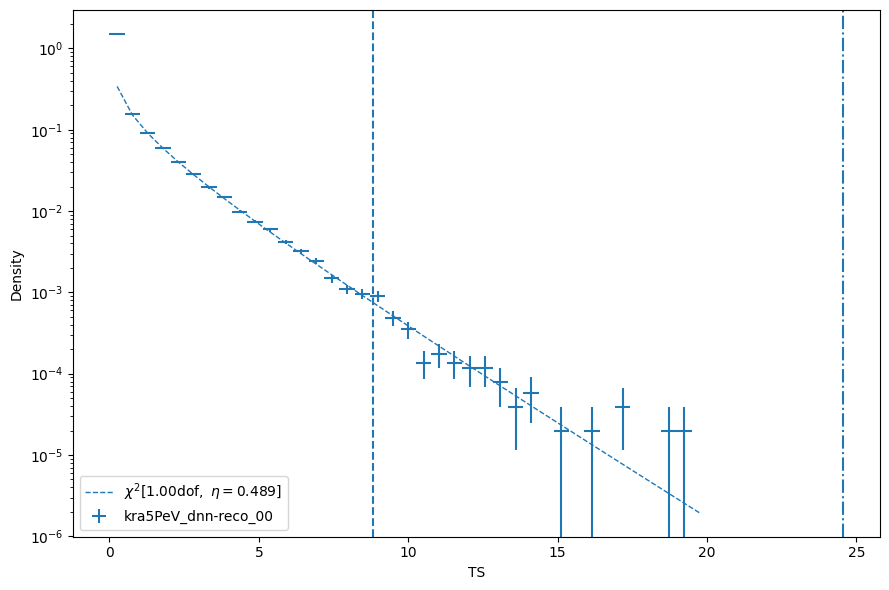

In [23]:
fig, ax = plt.subplots(figsize=(9, 6))
bins = np.linspace(0, 20, 40)
for i, (name, bg) in enumerate(bg_trials.items()):
    plot_bkg_trials(bg, fig=fig, ax=ax, label=name, color=colors[i], density=True, bins=bins)
    ax.axvline(bg.isf_nsigma(3), color=colors[i], ls='--')
    ax.axvline(bg.isf_nsigma(5), color=colors[i], ls='-.')

fig.tight_layout()

In [24]:
print('Sensitivity:')
for name, values in results.items():
    i = int(name.split('_')[-2])
    if 'sens' in name:
        print('  {:3.3f} [{:3.3f}, {:3.3f}] | {} | {} events'.format(
            values['model_norm'], 
            values['model_norm_lower'], 
            values['model_norm_upper'], 
            runners_to_check[i][1],
            name.split('_')[1],
        ))

print('5sigma Discovery Potential:')
for name, values in results.items():
    i = int(name.split('_')[-2])
    print()
    if 'disc' in name:
        print('  {:3.3f} [{:3.3f}, {:3.3f}] | {} | {} events'.format(
            values['model_norm'], 
            values['model_norm_lower'], 
            values['model_norm_upper'], 
            runners_to_check[i][1],
            name.split('_')[1],
        ))
        

Sensitivity:
  0.205 [0.199, 0.211] | $\Psi$ * $E_{kra-\gamma}$ [mod] | dnn-reco events
5sigma Discovery Potential:


  0.850 [0.841, 0.858] | $\Psi$ * $E_{kra-\gamma}$ [mod] | dnn-reco events


In [91]:
# Test systematic
raise NotImplementedError('Just an example...')

# (if only one llh model)
assert len(tr.llh_models) == 1

src = cy.utils.Sources(dec=0, ra=0, deg=True)
conf = {
        'src' : src, 
        'flux' : cy.hyp.PowerLawFlux(2.),
        'update_bg': True,
        'sigsub' :  True,
        'randomize' : ['ra', cy.inj.DecRandomizer],
        'sindec_bandwidth' : np.radians(5),
        'dec_rand_method' : 'gaussian_fixed',
        'dec_rand_kwargs' : dict(randomization_width = np.radians(3)),
        'dec_rand_pole_exlusion' : np.radians(8)
    }
truth, bg, sig = cy.conf.get_injs(a=a_cont, llh_model=tr.llh_models[0], llh_conf=llh_conf, conf=conf)

llh_conf = dict(tr.llh_kw)
llh_conf['src'] = src
truth, bg, sig = cy.conf.get_injs(a=a_sys, llh_model=tr.llh_models[0], llh_conf=llh_conf, conf=conf_sys)
tr.sig_injs = [sig]
tr.bg_injs = [bg]
tr.truth_injs = [truth]


NotImplementedError: Just an example...